In [1]:
import math
import keras
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D,Input,Multiply,RepeatVector,TimeDistributed,Add,Concatenate
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import random
import pandas as pd
import spectrogram
import MGD
import get_features
import importlib
import helper
import FCNN
import mix_noise
importlib.reload(helper)
importlib.reload(spectrogram)
importlib.reload(get_features)
importlib.reload(MGD)
importlib.reload(FCNN)
importlib.reload(mix_noise)
import matplotlib.pyplot as plt
import keras.backend as K
from tensorflow import keras
import json
from sklearn.metrics import f1_score
from keras.regularizers import l2

Using TensorFlow backend.


/home/lnw8px/.conda/envs/autokeras/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`
  from ipykernel import kernelapp as app


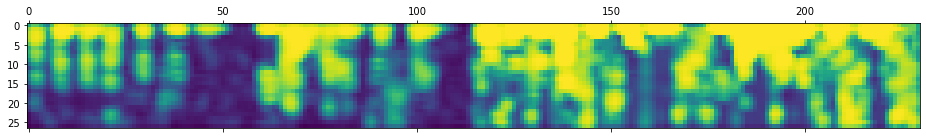

In [81]:
#observe attention
att_model=Model(input=model.input,outputs=model.get_layer("activation_9").output)
attention=att_model.predict(data)
attention=np.squeeze(attention)
plt.matshow(attention)

In [7]:
def get_means(data_list):
    spec_mean_list=[]
    MGD_mean_list=[]
    for d in data_list:
        data=d[0]
        data=np.expand_dims(data,axis=-1)
        data=np.expand_dims(data,axis=0)
        #observe attention
        att_model=Model(input=model.input,outputs=model.get_layer("activation_4").output)
        attention=att_model.predict(data)

        half_point=int(attention.shape[2]/2)
        spec_data=attention[0,:,0:half_point,0]
        MGD_data=attention[0,:,half_point:-1,0]
        spec_mean=np.mean(spec_data)
        MGD_mean=np.mean(MGD_data)

        spec_mean_list.append(spec_mean)
        MGD_mean_list.append(MGD_mean)
    spec_mean,MGD_mean=np.mean(np.array(spec_mean_list)),np.mean(np.array(MGD_mean_list))
    return spec_mean,MGD_mean
    

In [51]:
import librosa
import mix_noise
importlib.reload(mix_noise)

fft_len=25
fft_hop=int(fft_len*10/40)
height=int(200/40*fft_len)

noise_files=['crickets','alarm','kettle','rain','steps','thunder','traffic','vacume','airconditioner']
def get_white_noise_performance(model,data_df):
    print('white noise....')
    #appended acc,f1
    res_list=[]
    emo_breakdown_list=[]
    for SNR in range(-40,30,5):
        print('SNR='+str(SNR))
        SNR=-1*SNR
        if(SNR >= 40):
            SNR=50000
        noise_df=mix_noise.get_white_noise_dataframe(data_df,SNR=SNR)
        noise_list=helper.get_comb2_data_list(noise_df,fft_len,fft_hop,height)
        acc,f1,f1_list=helper.get_vali_acc(model,noise_list)
        res_list.append([acc,f1])
        emo_breakdown_list.append(f1_list)
    return res_list,emo_breakdown_list

def get_real_noise_performance(model,data_df,noise):
    print(noise)
    res_list=[]
    emo_breakdown_list=[]
    for SNR in range(-40,30,5):
        print('SNR='+str(SNR))
        SNR=-1*SNR
        if(SNR >= 40):
            SNR=50000
        noise_df=mix_noise.get_real_noise_dataframe(data_df,noise,SNR)
        noise_list=helper.get_comb2_data_list(noise_df,fft_len,fft_hop,height)
        acc,f1,f1_list=helper.get_vali_acc(model,noise_list)
        res_list.append([acc,f1])
        emo_breakdown_list.append(f1_list)
    return res_list,emo_breakdown_list



In [49]:
#create RAVDESS data
#get data from RAVDESS
fft_len=25 
fft_hop=int(fft_len*10/40)
height=int(200/40*fft_len)

random_df = pd.read_pickle('/scratch/lnw8px/RAVDESS_data/dataset_random.pkl')

#use only strong intensity
random_df=random_df[random_df['intensity']=='02']
#drop some emotions
random_df = random_df[(random_df['emotion']!='07')]
uniques=random_df['emotion'].unique()
#uniques=np.sort(uniques)
print(uniques)
for i in range(0,uniques.shape[0]):
    #i+1 because the onehot thinks index starts with 1. 
    random_df.loc[random_df['emotion']==uniques[i],'emotion']=str(i+1)
onehot=random_df['emotion'].apply(helper.to_onehot,args=(7,))
random_df['label']=onehot    
    

break_index=int(random_df.shape[0]*0.8)
train_df=random_df[0:break_index]
vali_df=random_df[break_index:-1]

['06' '08' '03' '02' '05' '04']


In [ ]:
#evaluate performance uder variouse SNR of real noises and white nosie
#for RAVDESS

path='/scratch/lnw8px/results/RAVDESS/ignore_emo/no_1_7/'
noise_results_file='/scratch/lnw8px/results/RAVDESS/ignore_emo/no_1_7/noise_results.txt'
    
model = load_model('/scratch/lnw8px/results/RAVDESS/ignore_emo/no_1_7/best_model.h5')
print(model)

#calculate performance under white nosie
white_noise_res_list,emo_breakdown_list=get_white_noise_performance(model,vali_df)

res='white_noise,' +str(white_noise_res_list)[1:-1] + '\n'
f = open(noise_results_file, "a")
f.write(res)
f.close()

np.save(path+'white_noise',arr=np.array(emo_breakdown_list))

#calculate performance under real worlds noises
path='/scratch/lnw8px/noises/noises/'
for noise_file in noise_files:
    noise_path=path+noise_file+'.wav'
    noise, sr = librosa.load(noise_path)
    real_noise_res_list,emo_breakdown_list=get_real_noise_performance(model,vali_df,noise)
    res=noise_file + ","+str(real_noise_res_list)[1:-1] + '\n'
    f = open(noise_results_file, "a")
    f.write(res)
    f.close()
    np.save(path+noise_file,arr=np.array(emo_breakdown_list))


In [ ]:
#For emo DB
#evaluate performance uder variouse SNR of real noises and white nosie

out_file='/scratch/lnw8px/results/emo_db_batch/noise_results.txt'
model_path='/scratch/lnw8px/results/emo_db_batch/'

for fold in range(0,10):
    
    #extract data from the fold and calculate features
    train_df,vali_df=helper.get_fold(fold=fold)
    
    #load model
    model_name=model_path+'fold_1_'+str(fold)+'.h5'
    model = load_model(model_name)
    print(model_name)
    
    #calculate performance under white nosie
    white_noise_res_list,emo_breakdown_list=get_white_noise_performance(model,vali_df)    
    res=str(fold) + ',white_noise,' +str(white_noise_res_list)[1:-1] + '\n'
    f = open(out_file, "a")
    f.write(res)
    f.close()
    
    np.save(model_path+str(fold)+'_white_noise',arr=np.array(emo_breakdown_list))


    #calculate performance under real worlds noises
    path='/scratch/lnw8px/noises/noises/'
    for noise_file in noise_files:
        noise_path=path+noise_file+'.wav'
        noise, sr = librosa.load(noise_path)
        real_noise_res_list,emo_breakdown_list=get_real_noise_performance(model,vali_df,noise)
        res=str(fold) + ',' + noise_file + ","+str(real_noise_res_list)[1:-1] + '\n'
        f = open(out_file, "a")
        f.write(res)
        f.close()
        
        np.save(model_path+str(fold)+"_"+noise_file,arr=np.array(emo_breakdown_list))